# L4 Eulerian comparison

- visualization of the observations repartition (time & space)
- spatial plots on the mediterranean sea to see the comparison
- statistics distribution to see the repartition of field & drifters velocities 

In [5]:
import os
import sys
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
import utils_plots

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


path_data = '../save_data/eulerian_dataframes/'
path_save_plot = '../save_plots/save_plots_2024-06-25_Eulerian_comparison_weighted'

#### functions

In [6]:

def plot2d(lon, lat, data, bbox: tuple=BBOX_DRIFTERS, vmax=None, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if not vmax:
        vmax = np.nanmax(data)
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmin = np.nanmin(data)

    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')


    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [7]:
def create_luminosity_colormap():
    """
    Create a custom colormap based on luminosity levels.
    
    Returns:
    matplotlib.colors.LinearSegmentedColormap: Custom luminosity colormap.
    """
    colors = [(i / 256.0, i / 256.0, i / 256.0) for i in range(256)]
    luminosity_colormap = matplotlib.colors.LinearSegmentedColormap.from_list("luminosity_colormap", colors, N=256)
    return luminosity_colormap

def plot2d_weighted(lon, lat, data, plot_density=True, n_obs=None, bbox: tuple=BBOX_DRIFTERS, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    # 2D data
    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')

    if plot_density:
        # plot density of observations with luminosity
        luminosity_grid = n_obs
        luminosity_colormap = create_luminosity_colormap()
        obs = ax.contour(lon, lat, luminosity_grid, levels=np.array([400, 800, 1200, 1600, 2000, 2400, 2800])*0.5, transform=crs, cmap=luminosity_colormap, alpha=0.2)
        #ax.colorbar(label='Number of Observations', orientation='horizontal')
        cbar2 = plt.colorbar(obs, label='Number of Observations', ax=ax, orientation='horizontal', pad=0.08)

    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

#### Load data and compute metrics

In [8]:
#open dataframe
df = vaex.open(os.path.join(path_data, 'L4_eulerian_comparison_dataframe.hdf5'))

print('Number of observations : ', len(df))
df[:3]

Number of observations :  278342


#,id,time,lat,lon,u_drifter,v_drifter,u_geo_swot,v_geo_swot,u_var_swot,v_var_swot,u_geo_nadir,v_geo_nadir,u_var_nadir,v_var_nadir
0,300534061395960,2023-05-04 20:30:00.000000000,40.838,4.928,0.0453329,0.092028,0.029415,0.0275543,0.0325819,0.0358694,0.0520057,0.0161717,0.056405,0.0212609
1,300534061395960,2023-05-04 21:00:00.000000000,40.8393,4.92894,0.0453765,0.0982447,0.0306838,0.0267035,0.0339472,0.0349416,0.0531859,0.0153913,0.0576284,0.0204497
2,300534061395960,2023-05-04 21:30:00.000000000,40.8407,4.92986,0.0454667,0.104298,0.0319728,0.0258642,0.0353347,0.0340295,0.0543722,0.0146114,0.0588588,0.0196398


In [9]:
# compute metrics
df['L2_norm_geoswot'] = np.sqrt( (df.u_geo_swot - df.u_drifter)**2 + (df.v_geo_swot - df.v_drifter)**2)
df['L2_norm_varswot'] = np.sqrt( (df.u_var_swot - df.u_drifter)**2 + (df.v_var_swot - df.v_drifter)**2)
df['L2_norm_geonadir'] = np.sqrt( (df.u_geo_nadir - df.u_drifter)**2 + (df.v_geo_nadir - df.v_drifter)**2)
df['L2_norm_varnadir'] = np.sqrt( (df.u_var_nadir - df.u_drifter)**2 + (df.v_var_nadir - df.v_drifter)**2)

# compa drifter/satellite
df['swotnadircyclo_rel_amelioration'] = (df['L2_norm_varswot'] - df['L2_norm_varnadir']) / df['L2_norm_varnadir'] 
df['swotnadirgeo_rel_amelioration'] = (df['L2_norm_geoswot'] - df['L2_norm_geonadir']) / df['L2_norm_geonadir'] 


# compa satellite/satellite
df['L2_norm_swotnadir_geo'] = np.sqrt( (df.u_geo_swot - df.u_geo_nadir)**2 + (df.v_geo_swot - df.v_geo_nadir)**2)
df['L2_norm_swotnadir_cyclo'] = np.sqrt( (df.u_var_swot - df.u_var_nadir)**2 + (df.v_var_swot - df.v_var_nadir)**2)

df['L2_norm_swotnadir_geo'] = np.sqrt( (df.u_geo_swot - df.u_geo_nadir)**2 + (df.v_geo_swot - df.v_geo_nadir)**2)
df['L2_norm_swotnadir_cyclo'] = np.sqrt( (df.u_var_swot - df.u_var_nadir)**2 + (df.v_var_swot - df.v_var_nadir)**2)


# angle & mag drifter/satellite
U_drifter = df.u_drifter.values + 1j * df.v_drifter.values

U_geoswot = df.u_geo_swot.values + 1j * df.v_geo_swot.values
U_varswot = df.u_var_swot.values + 1j * df.v_var_swot.values
U_geonadir = df.u_geo_nadir.values + 1j * df.v_geo_nadir.values
U_varnadir = df.u_var_nadir.values + 1j * df.v_var_nadir.values

df['diffarg_geoswot'] = np.angle(U_geoswot / U_drifter) 
df['diffarg_varswot'] = np.angle(U_varswot / U_drifter) 
df['diffarg_geonadir'] = np.angle(U_geonadir / U_drifter) 
df['diffarg_varnadir'] = np.angle(U_varnadir / U_drifter) 

df['diffabs_geoswot'] = np.abs(U_geoswot) - np.abs(U_drifter) 
df['diffabs_varswot'] = np.abs(U_varswot) - np.abs(U_drifter) 
df['diffabs_geonadir'] = np.abs(U_geonadir) - np.abs(U_drifter) 
df['diffabs_varnadir'] = np.abs(U_varnadir) - np.abs(U_drifter) 

df['ratioabs_geoswot'] = np.abs(U_geoswot) / np.abs(U_drifter) 
df['ratioabs_varswot'] = np.abs(U_varswot) / np.abs(U_drifter) 
df['ratioabs_geonadir'] = np.abs(U_geonadir) / np.abs(U_drifter) 
df['ratioabs_varnadir'] = np.abs(U_varnadir) / np.abs(U_drifter) 

In [10]:
# defines the grid to apply statistics

resolution = 0.15 #°
lon_grid = np.arange(df.lon.min(), df.lon.max(), resolution)
lat_grid = np.arange(df.lat.min(), df.lat.max(), resolution)

n_lat, n_lon = lat_grid.shape[0], lon_grid.shape[0]
print('resolution : ', resolution, '\ngrid shape (lat, lon): ', n_lat, n_lon)


# Compute the means on the grid
columns_to_mean = df.column_names[4:]
mean_grid = {col: df.mean(df[col], binby=[df['lon'], df['lat']], shape=(n_lon, n_lat)).T for col in columns_to_mean}

resolution :  0.15 
grid shape (lat, lon):  63 123


In [11]:
#define the indexes of the grid that are under the swath of SWOT
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

swath_idx = isin_swath(lon_mesh, lat_mesh)
swath_idx.shape

(63, 123)

## Observations repartition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


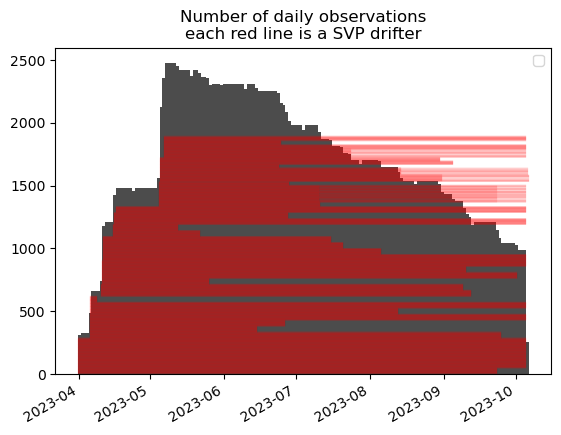

In [12]:
plt.hist(df['time'], bins=165, color='black', alpha=0.7, zorder=1)


# plot drifters livespan lines
start_times = np.load('utils_data/start.npy')
end_times   = np.load('utils_data/end.npy')
order = np.argsort(start_times)
start_times = start_times[order]
end_times = end_times[order]
factor = 1.7
lw = 0.02
plt.plot([start_times[0], end_times[0]], [1*factor, 1*factor], color='r', lw=lw, zorder=2)
for k in range(1, start_times.shape[0]):
    plt.plot([start_times[k], end_times[k]], [(k+1)*factor, (k+1)*factor], color='r', lw=0.1, zorder=2)
plt.gcf().autofmt_xdate()
plt.title('Number of daily observations\neach red line is a SVP drifter')
plt.legend()

In [9]:
DENSITY, lat_edges, lon_edges = np.histogram2d(df.lat.values, df.lon.values, bins=(n_lat, n_lon), range=None, density=False)

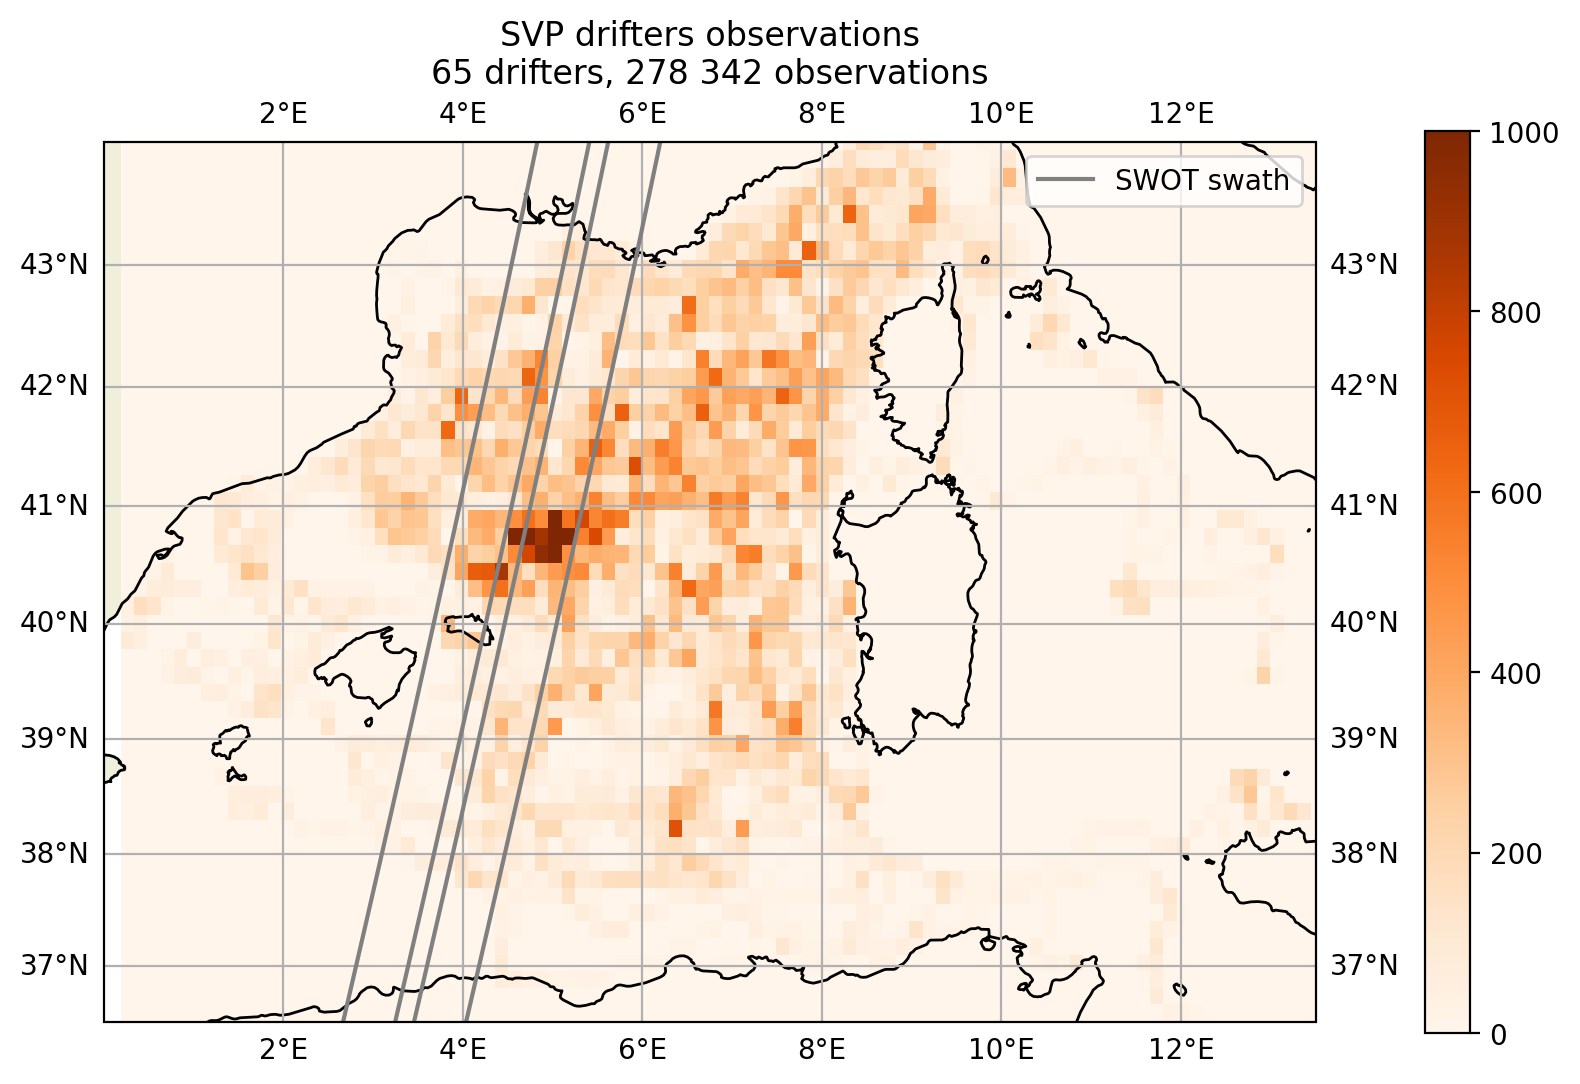

In [21]:
# Set up the figure and map projection
fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
_ = ax.gridlines(draw_labels=True,)

# Add land feature for better visualization
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# Set the map extent
ax.set_extent(bbox_drifters, crs=crs)

# Plot the density of points
vmax=1000
vmin=0



# 2D data
mesh = ax.pcolormesh(lon_edges, lat_edges, DENSITY, transform=crs, cmap='Oranges', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.033, pad=0.08)
#cbar.set_label('Density')

#plot SWATH
x1, x2, x3, x4, y_down, y_up, x_up = 2.85, 3.43, 3.64, 4.32, 37.14, 43.76, 4.76
pente = (x_up - x1) / (y_up - y_down)

X = np.linspace(-5, 5, 100)
Y = X / pente + y_down
ax.plot(X+x1, Y, zorder=2, transform=crs, c='grey', label='SWOT swath')
ax.plot(X+x2, Y, zorder=2, transform=crs, c='grey')
ax.plot(X+x3, Y, zorder=2, transform=crs, c='grey')
ax.plot(X+x4-0.1, Y, zorder=2, transform=crs, c='grey')

ax.set_title('SVP drifters observations\n65 drifters, 278 342 observations')
ax.legend()

plt.savefig(os.path.join('/home/bouxdecl/Documents/FINAL_VISU/IMG', 'Observations_SVP_space.png'), bbox_inches='tight', dpi = 300)

## Spatial Plots

### Relative amelioration with the SWOT satellite to predict the drifters velocities  

- compute the mean for each $||U_{field}-U_{drifter}||$ values weighted by the observation density on a grid accross the mediterranean sea
- compute on the grid the relative amelioration fraction (and remove outliers) :

$$\frac{ ||U_{allnadirs+swot}-U_{drifter}|| \;\; - \;\; ||U_{allnadirs}-U_{drifter}||}{||U_{allnadirs}-U_{drifter}||}$$

esperance = -0.02907333316973604


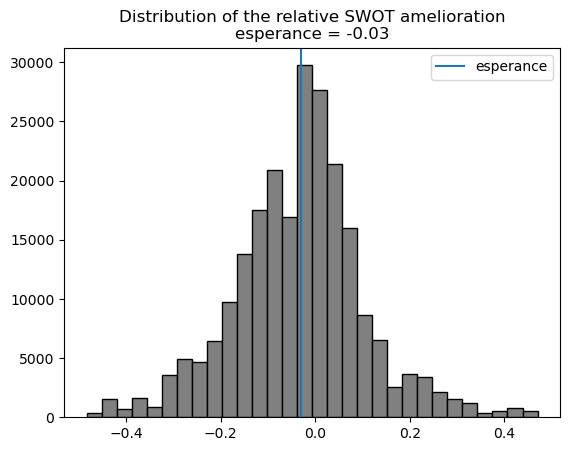

In [14]:
data = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / mean_grid['L2_norm_varnadir']

# Remove points outside 2 standart deviation
data, density = remove_outliers(data, DENSITY, zscore=2)

#plot histogram of the distribution
esperance = np.nansum(data * density / np.nansum(density))
print('esperance =', esperance)

hist, bins, _ = plt.hist( data.flatten(), weights=density.flatten(), bins=30, color='grey', edgecolor='black')
plt.title('Distribution of the relative SWOT amelioration\nesperance = {:.2f}'.format(esperance) )
plt.axvline(esperance, label='esperance')
plt.legend()

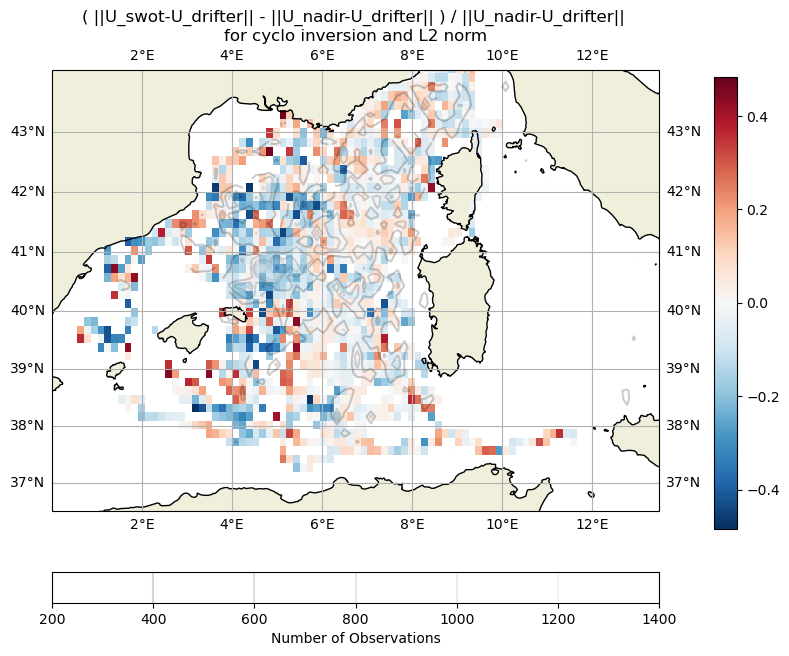

In [31]:
plot2d_weighted(lon_grid, lat_grid, data, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

only inside the swath

esperance = -0.10552251768563452


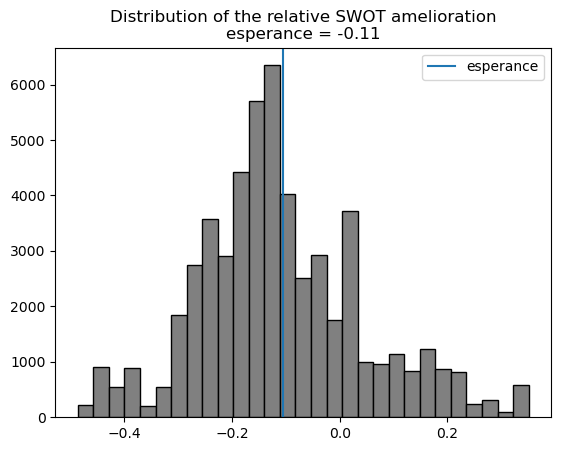

In [16]:
data = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / mean_grid['L2_norm_varnadir']

# takes only in swath
data[~swath_idx] = np.nan
density[~swath_idx] = np.nan

# Remove points outside 2 standart deviation
data, density = remove_outliers(data, density, zscore=2)

#plot histogram of the distribution
esperance = np.nansum(data * density / np.nansum(density))
print('esperance =', esperance)

hist, bins, _ = plt.hist( data.flatten(), weights=density.flatten(), bins=30, color='grey', edgecolor='black')
plt.title('Distribution of the relative SWOT amelioration\nesperance = {:.2f}'.format(esperance) )
plt.axvline(esperance, label='esperance')
plt.legend()

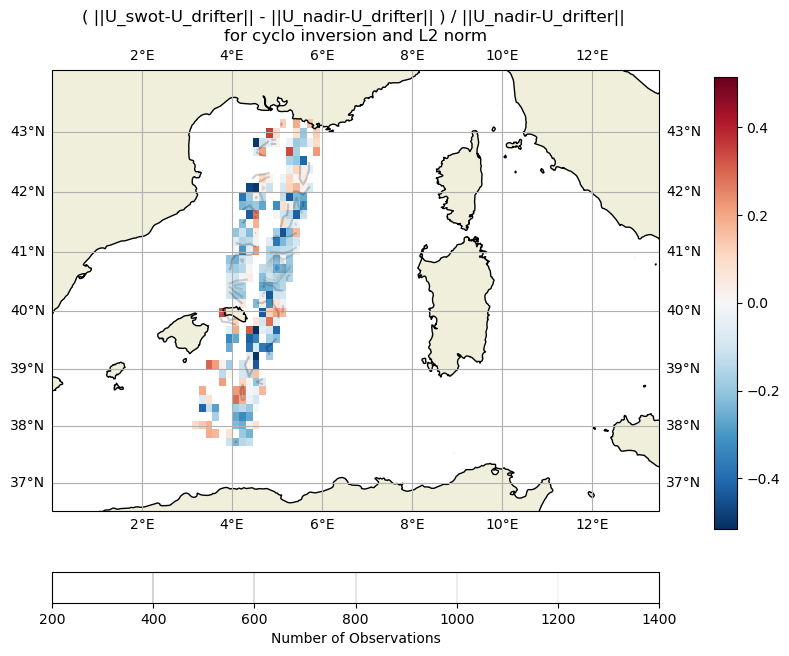

In [39]:
plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

### Comparison between fields $||U_{allnadirs+swot}-U_{allnadirs}||$

We see that there is more signal on the SWOT swath

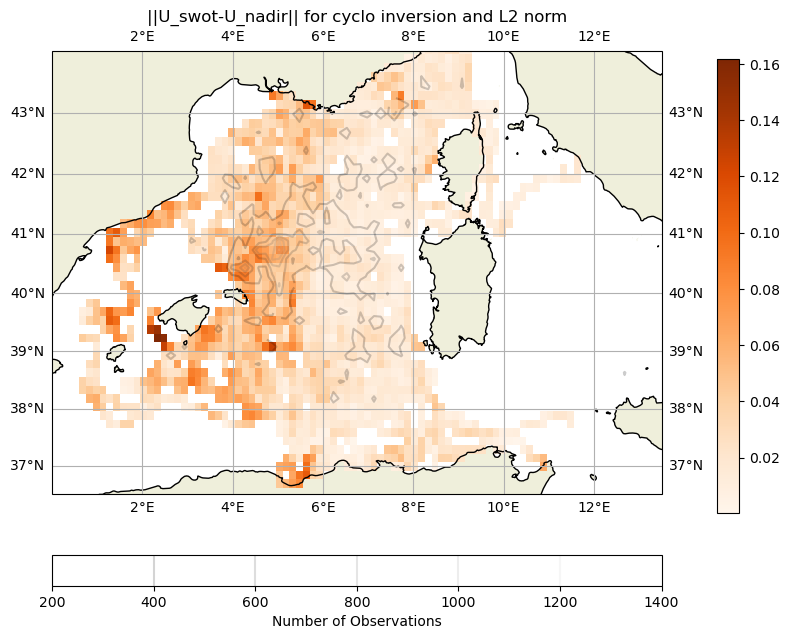

In [41]:
data = mean_grid['L2_norm_swotnadir_geo']

plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='Oranges', center_bar=False, title='||U_swot-U_nadir|| for cyclo inversion and L2 norm')  

### Deviation between drifters and geostrophie in degrees $^{\circ}$

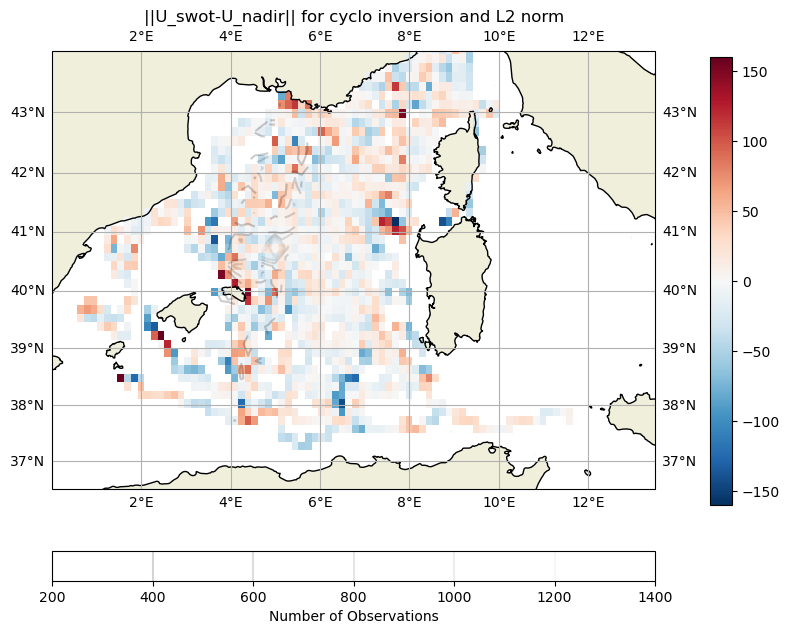

In [40]:
data = normalize_angle(mean_grid['diffarg_varswot']*180/np.pi)

plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='RdBu_r', center_bar=True, title='||U_swot-U_nadir|| for cyclo inversion and L2 norm')  

## Vectors caracteristics

- compare the norm and deviation of field and drifters velocity vectors over all comparison or just the under-swath observations

#### over all mediterranea

In [85]:
NORM_GEO = np.array(df['ratioabs_geonadir'].values)
ANGLE_GEO = np.array(df['diffarg_geonadir'].values)

NORM_VAR = np.array(df['ratioabs_varswot'].values)
ANGLE_VAR = np.array(df['diffarg_varswot'].values)

In [86]:

#sanitize
nan_index = np.isnan(NORM_GEO)
NORM_GEO = NORM_GEO[~nan_index]
ANGLE_GEO = ANGLE_GEO[~nan_index]

rmax = 3
idx_outliers = NORM_GEO < rmax

# get norm and theta
r_geo  = NORM_GEO[idx_outliers]
theta_geo = ANGLE_GEO[idx_outliers]


#sanitize
nan_index = np.isnan(NORM_VAR)
NORM_VAR = NORM_VAR[~nan_index]
ANGLE_VAR = ANGLE_VAR[~nan_index]

rmax = 3
idx_outliers = NORM_VAR < rmax

# get norm and theta
r_var  = NORM_VAR[idx_outliers]
theta_var = ANGLE_VAR[idx_outliers]

Text(0.5, 1.0, '|U field| / |U drifter| L4 field')

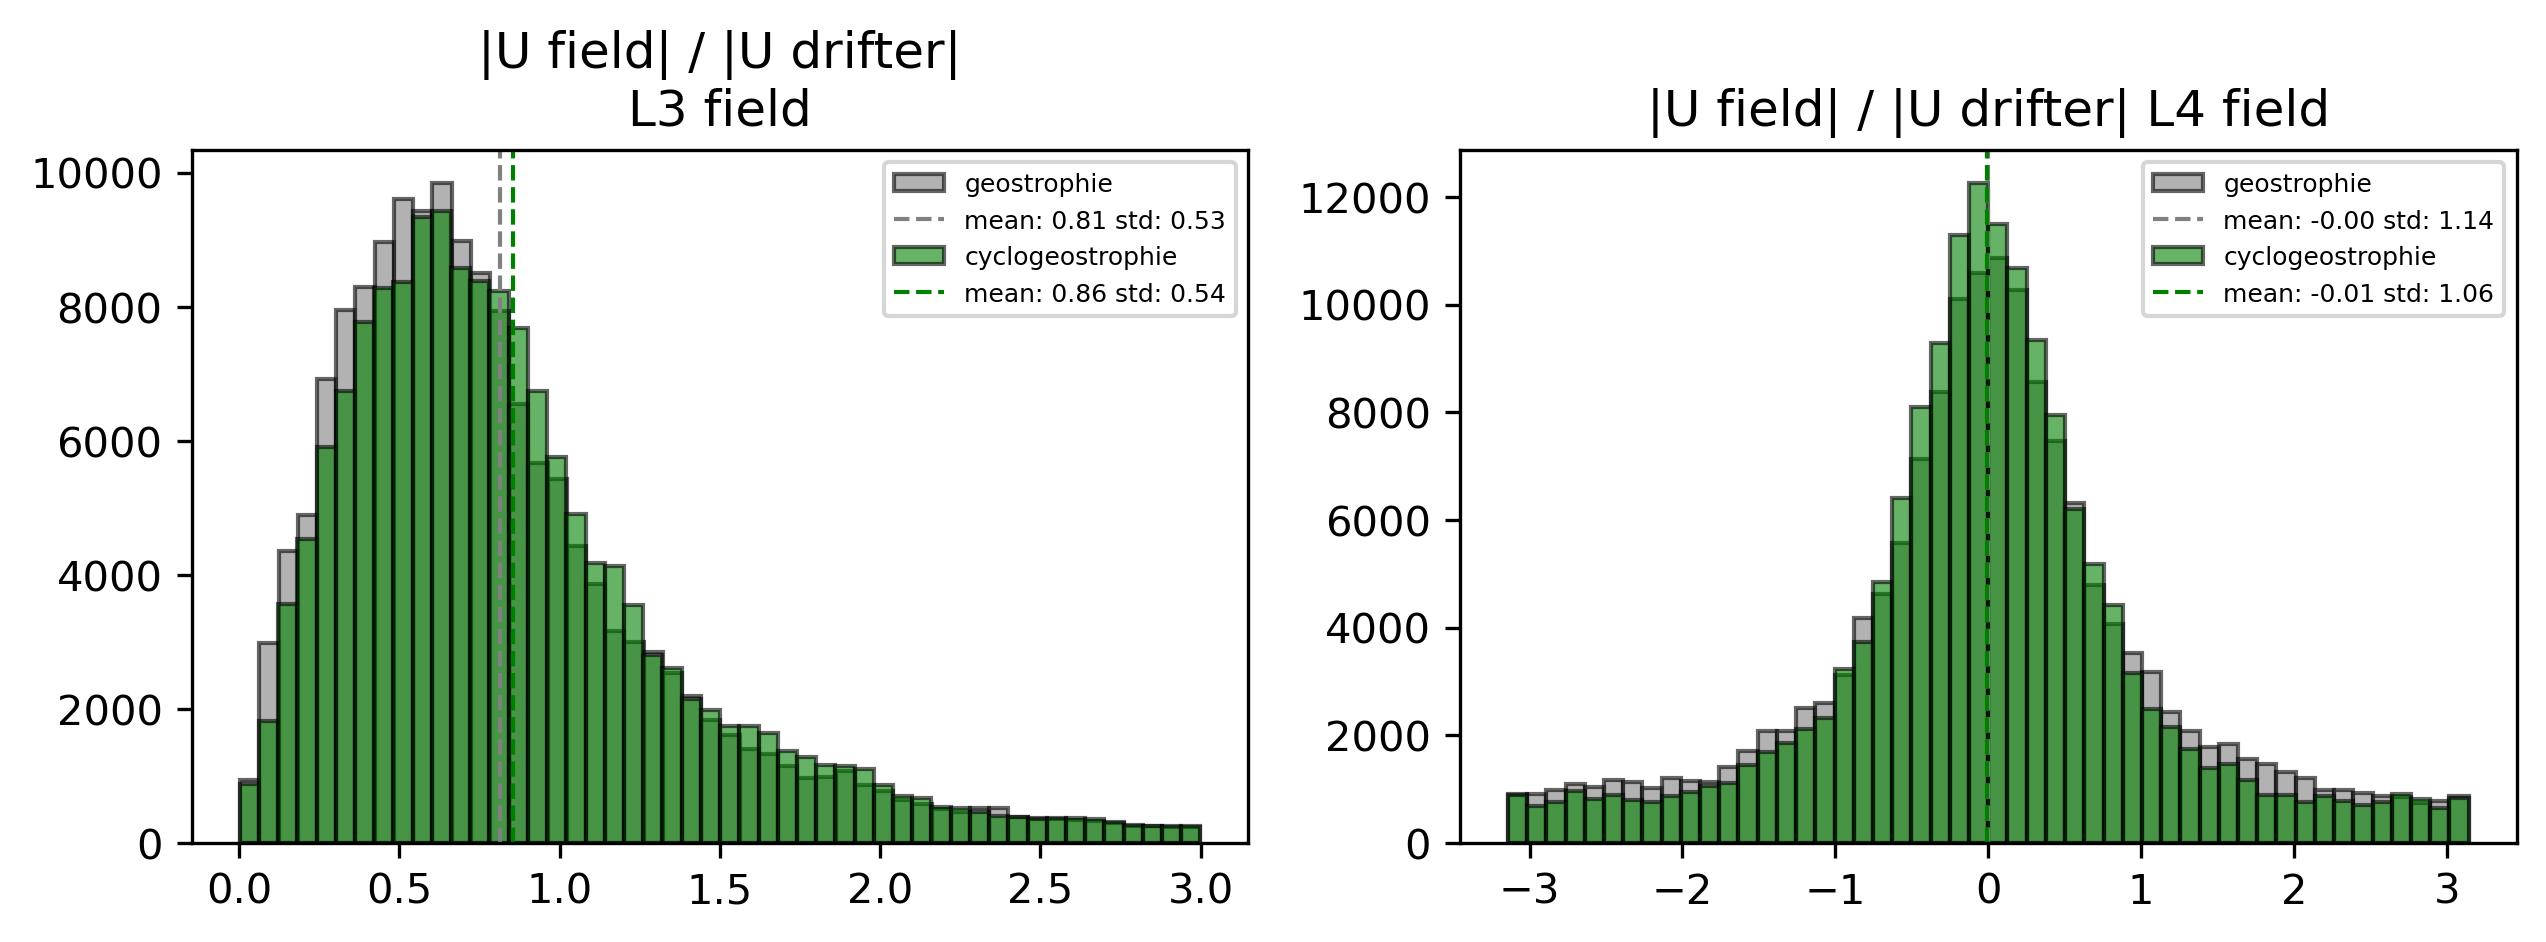

In [87]:
matplotlib.rcParams['figure.dpi'] = 300


plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
r  = r_geo
counts, bins, patches = plt.hist(r, bins=50, alpha=0.6, color='grey', edgecolor='black', label='geostrophie')
plt.axvline(r.mean(), color='grey', linestyle='dashed', linewidth=1, label=f'mean: {r.mean():.2f} std: {r.std():.2f}')

r = r_var
counts, bins, patches = plt.hist(r, bins=50, alpha=0.6, color='green', edgecolor='black', label='cyclogeostrophie')
plt.axvline(r.mean(), color='green', linestyle='dashed', linewidth=1, label=f'mean: {r.mean():.2f} std: {r.std():.2f}')
plt.legend(prop={'size': 6})
plt.title('|U field| / |U drifter|\nL3 field')

plt.subplot(1, 2, 2)
theta  = theta_geo
counts, bins, patches = plt.hist(theta, bins=50, alpha=0.6, color='grey', edgecolor='black', label='geostrophie')
plt.axvline(theta.mean(), color='grey', linestyle='dashed', linewidth=1, label=f'mean: {theta.mean():.2f} std: {theta.std():.2f}')

theta = theta_var
counts, bins, patches = plt.hist(theta, bins=50, alpha=0.6, color='green', edgecolor='black', label='cyclogeostrophie')
plt.axvline(theta.mean(), color='green', linestyle='dashed', linewidth=1, label=f'mean: {theta.mean():.2f} std: {theta.std():.2f}')
plt.legend(prop={'size': 6})
plt.title('|U field| / |U drifter| L4 field')

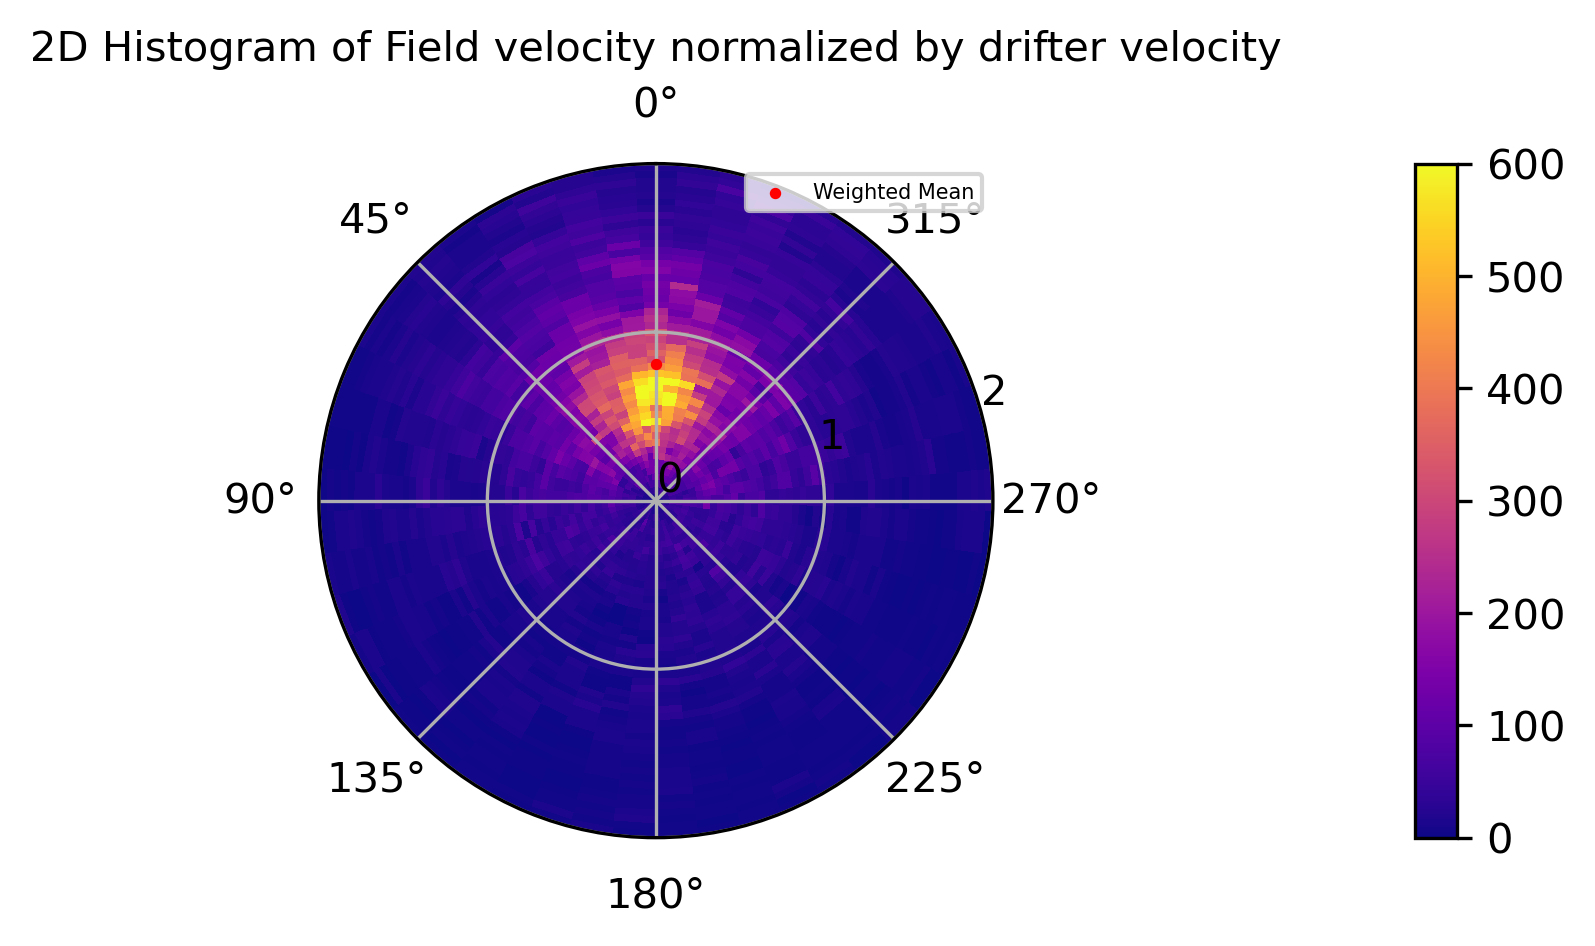

In [90]:
matplotlib.rcParams['figure.dpi'] = 300
utils_plots.plot_2d_polar_hist(r_geo, theta_geo, rmax=2, vmax = 600, )

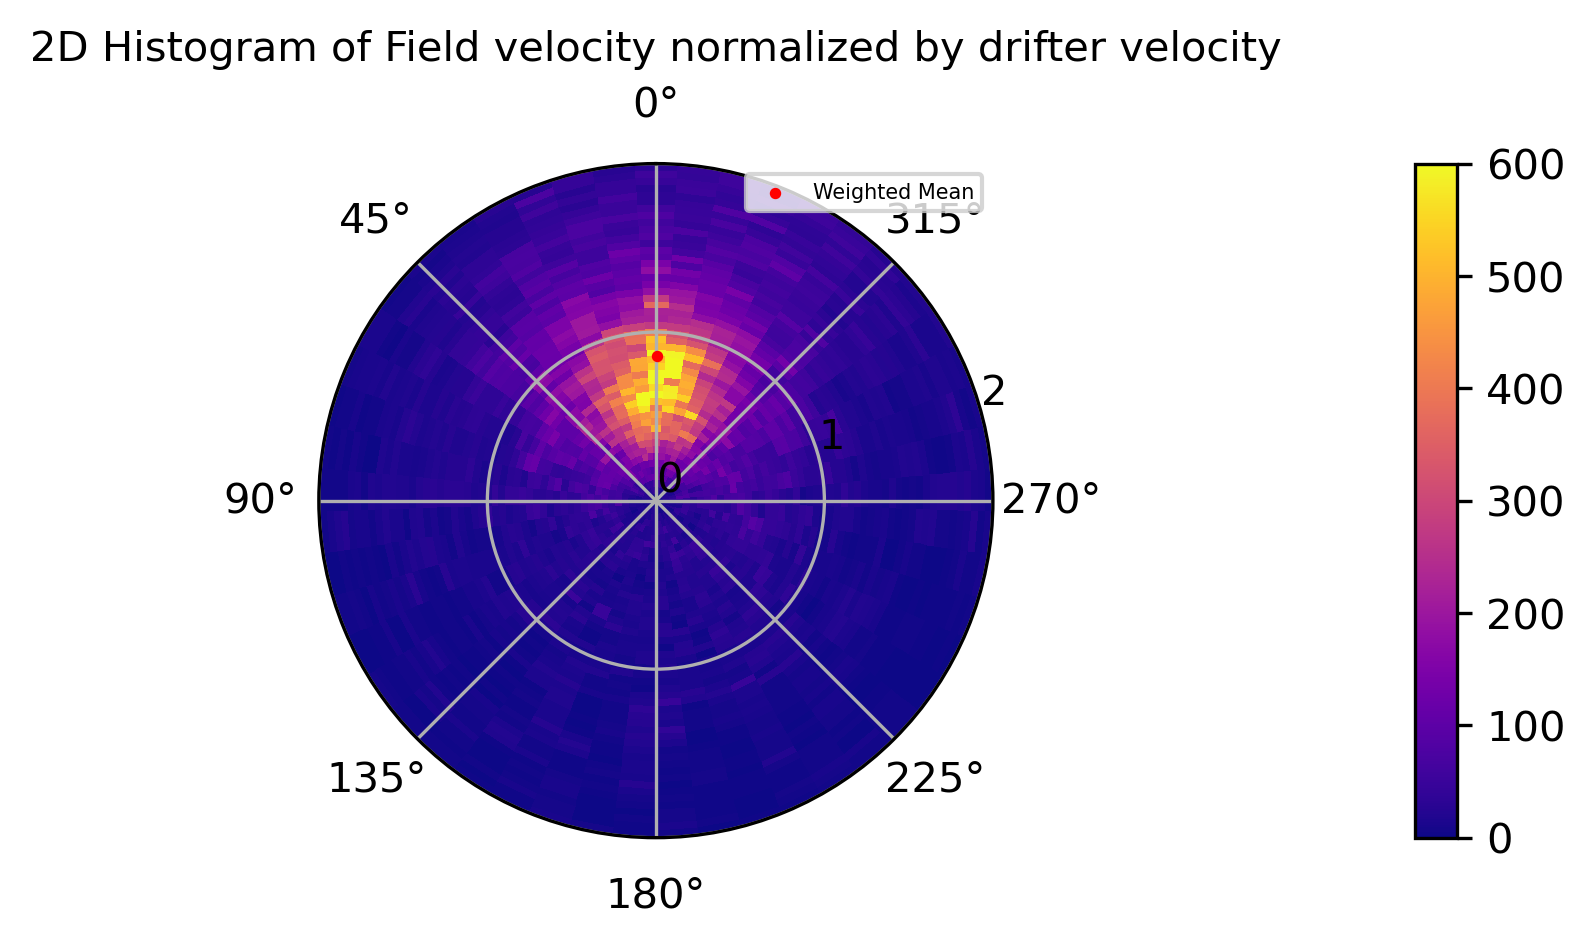

In [91]:
matplotlib.rcParams['figure.dpi'] = 300
utils_plots.plot_2d_polar_hist(r_var, theta_var, rmax=2, vmax = 600, )

#### Only on Swath

In [11]:
mask = isin_swath(df['lon'].values, df['lat'].values)

NORM_GEO = np.array(df['ratioabs_geoswot'].values)[mask]
ANGLE_GEO = np.array(df['diffarg_geoswot'].values)[mask]

NORM_VAR = np.array(df['ratioabs_varswot'].values)[mask]
ANGLE_VAR = np.array(df['diffarg_varswot'].values)[mask]

In [12]:

#sanitize
nan_index = np.isnan(NORM_GEO)
NORM_GEO = NORM_GEO[~nan_index]
ANGLE_GEO = ANGLE_GEO[~nan_index]

rmax = 3
idx_outliers = NORM_GEO < rmax

# get norm and theta
r_geo  = NORM_GEO[idx_outliers]
theta_geo = ANGLE_GEO[idx_outliers]


#sanitize
nan_index = np.isnan(NORM_VAR)
NORM_VAR = NORM_VAR[~nan_index]
ANGLE_VAR = ANGLE_VAR[~nan_index]

rmax = 3
idx_outliers = NORM_VAR < rmax

# get norm and theta
r_var  = NORM_VAR[idx_outliers]
theta_var = ANGLE_VAR[idx_outliers]

Text(0.5, 1.0, 'np.angle(U field / U drifter)\nL4 field on swath')

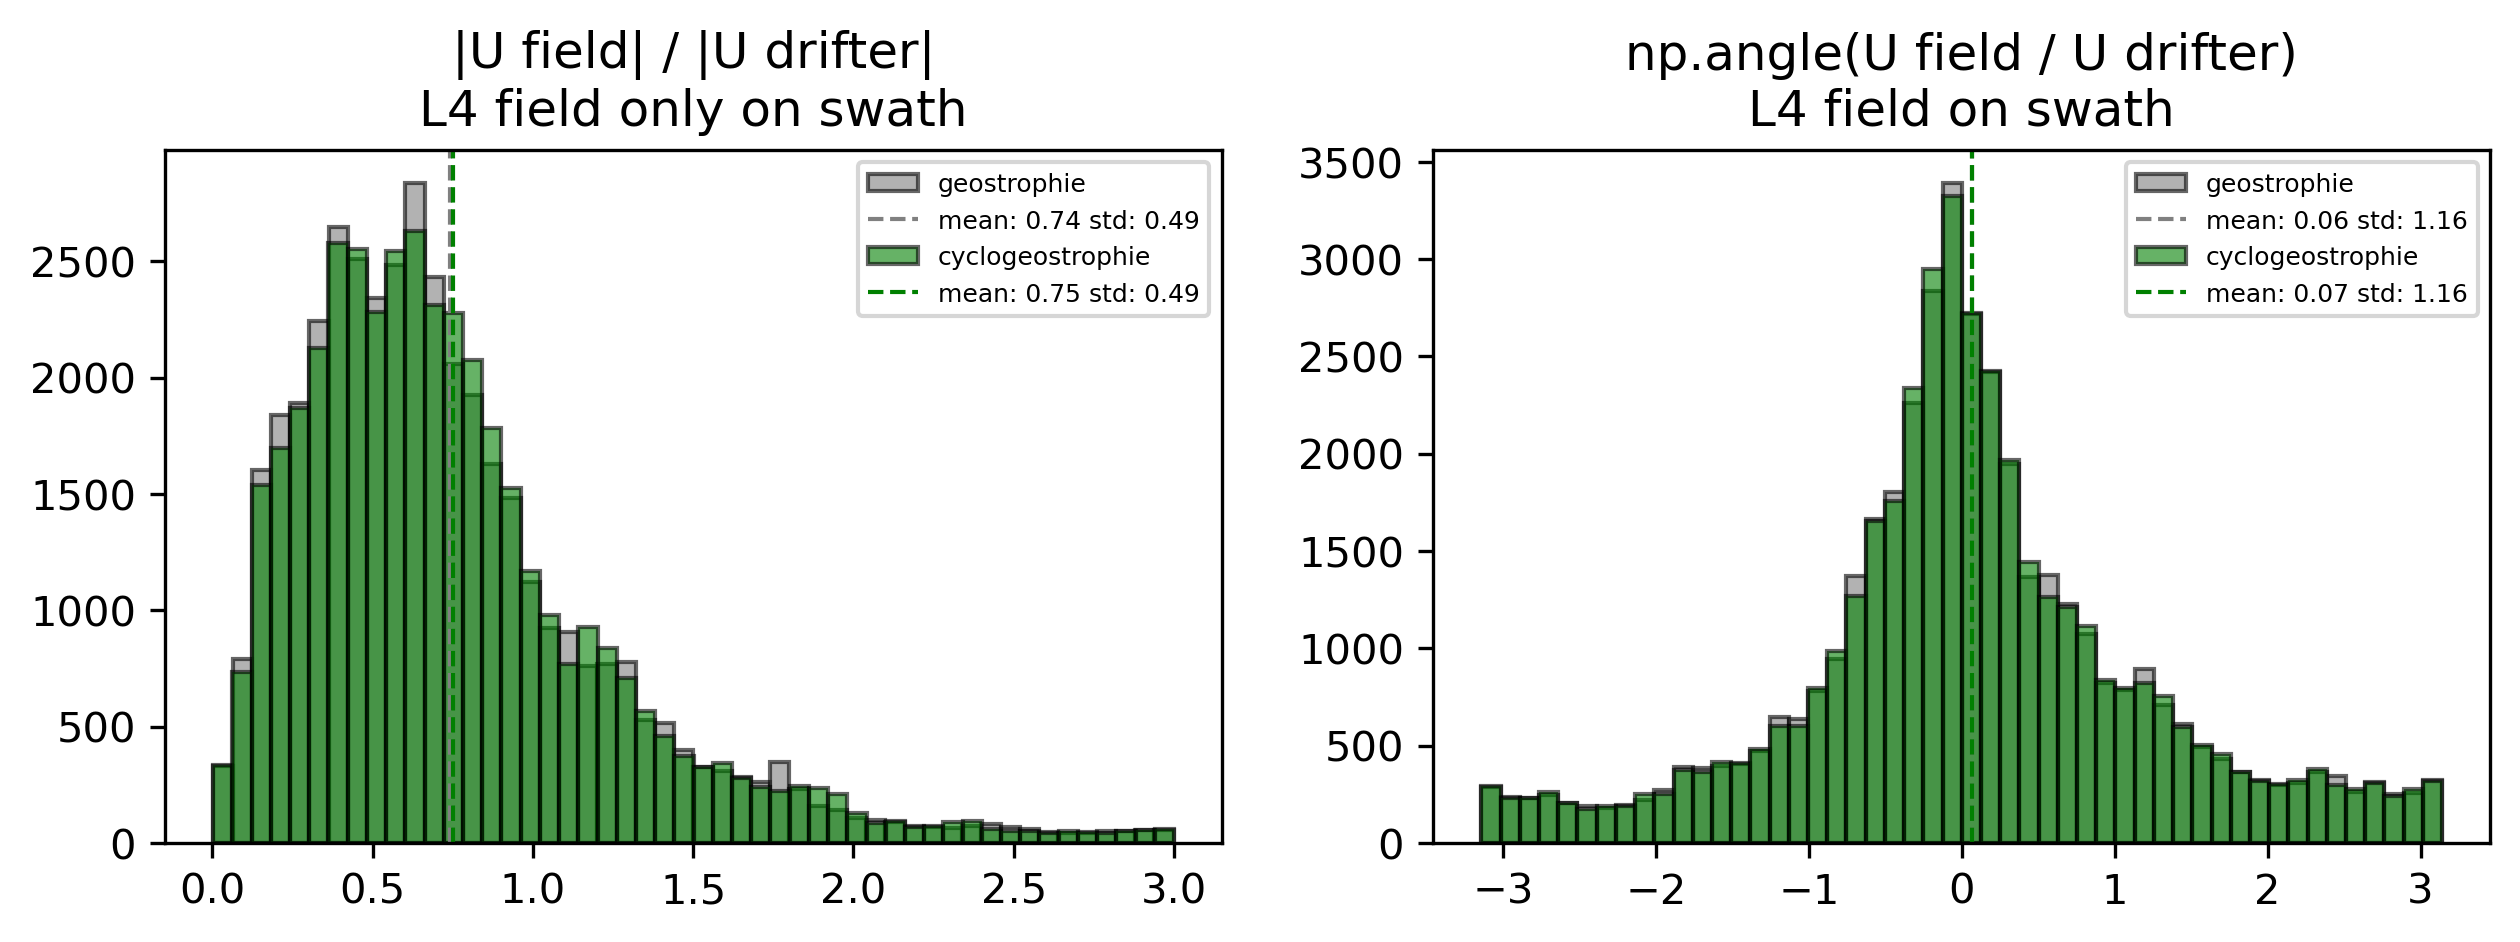

In [17]:
matplotlib.rcParams['figure.dpi'] = 300


plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
r  = r_geo
counts, bins, patches = plt.hist(r, bins=50, alpha=0.6, color='grey', edgecolor='black', label='geostrophie')
plt.axvline(r.mean(), color='grey', linestyle='dashed', linewidth=1, label=f'mean: {r.mean():.2f} std: {r.std():.2f}')

r = r_var
counts, bins, patches = plt.hist(r, bins=50, alpha=0.6, color='green', edgecolor='black', label='cyclogeostrophie')
plt.axvline(r.mean(), color='green', linestyle='dashed', linewidth=1, label=f'mean: {r.mean():.2f} std: {r.std():.2f}')
plt.legend(prop={'size': 6})
plt.title('|U field| / |U drifter|\nL4 field only on swath')

plt.subplot(1, 2, 2)
theta  = theta_geo
counts, bins, patches = plt.hist(theta, bins=50, alpha=0.6, color='grey', edgecolor='black', label='geostrophie')
plt.axvline(theta.mean(), color='grey', linestyle='dashed', linewidth=1, label=f'mean: {theta.mean():.2f} std: {theta.std():.2f}')

theta = theta_var
counts, bins, patches = plt.hist(theta, bins=50, alpha=0.6, color='green', edgecolor='black', label='cyclogeostrophie')
plt.axvline(theta.mean(), color='green', linestyle='dashed', linewidth=1, label=f'mean: {theta.mean():.2f} std: {theta.std():.2f}')
plt.legend(prop={'size': 6})
plt.title('np.angle(U field / U drifter)\nL4 field on swath')

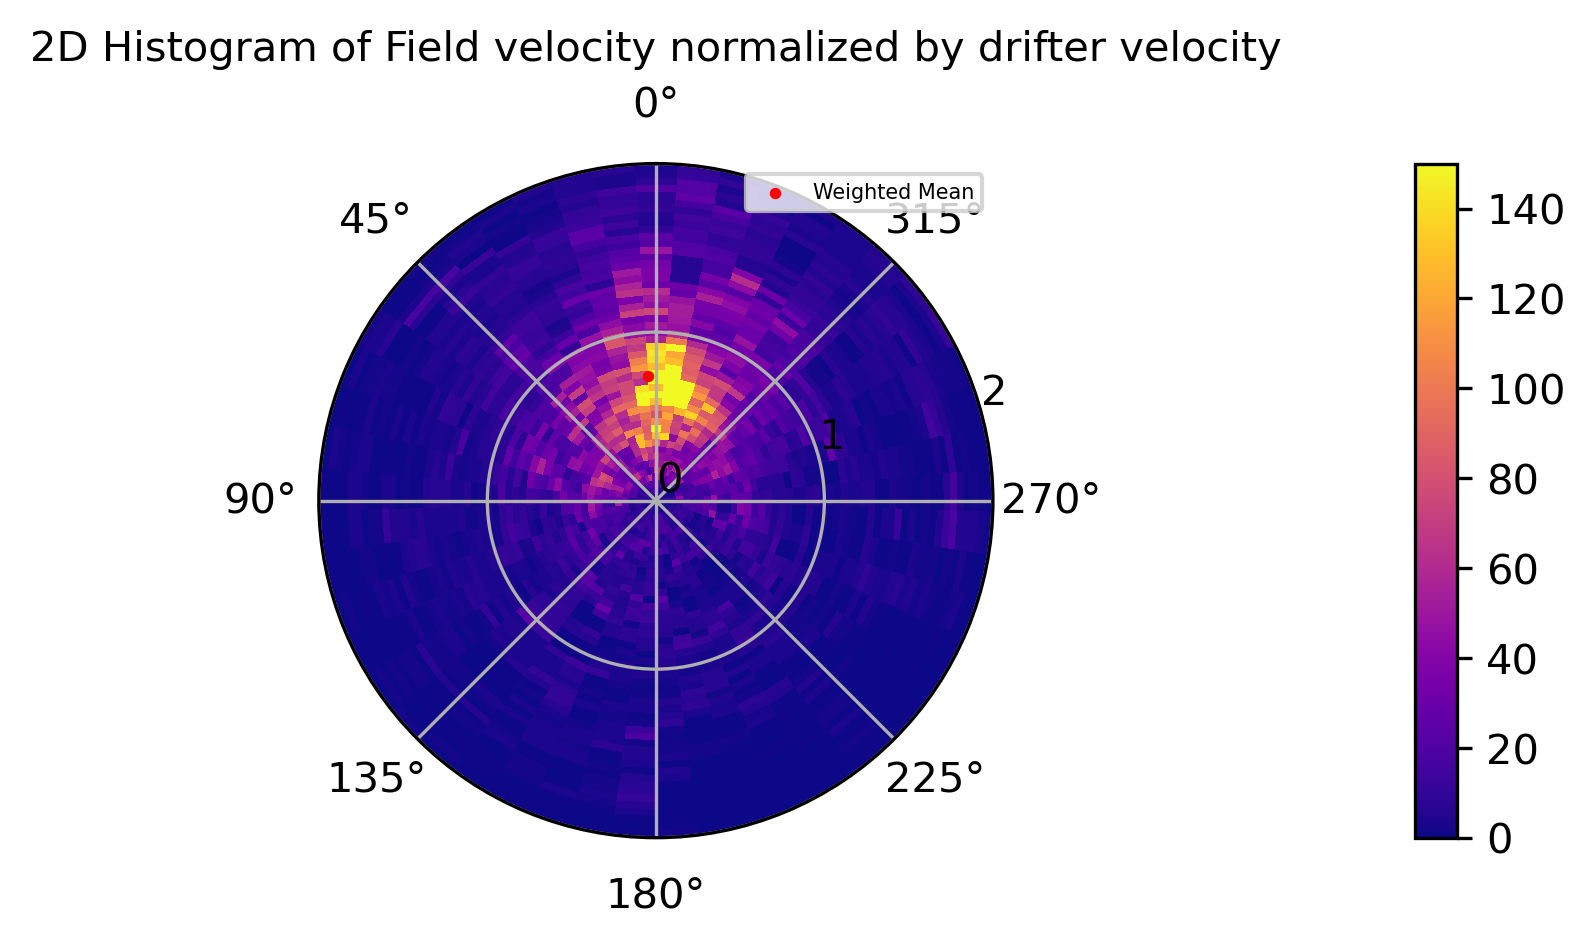

In [18]:
matplotlib.rcParams['figure.dpi'] = 300
utils_plots.plot_2d_polar_hist(r_geo, theta_geo, rmax=2, vmax = 150, )

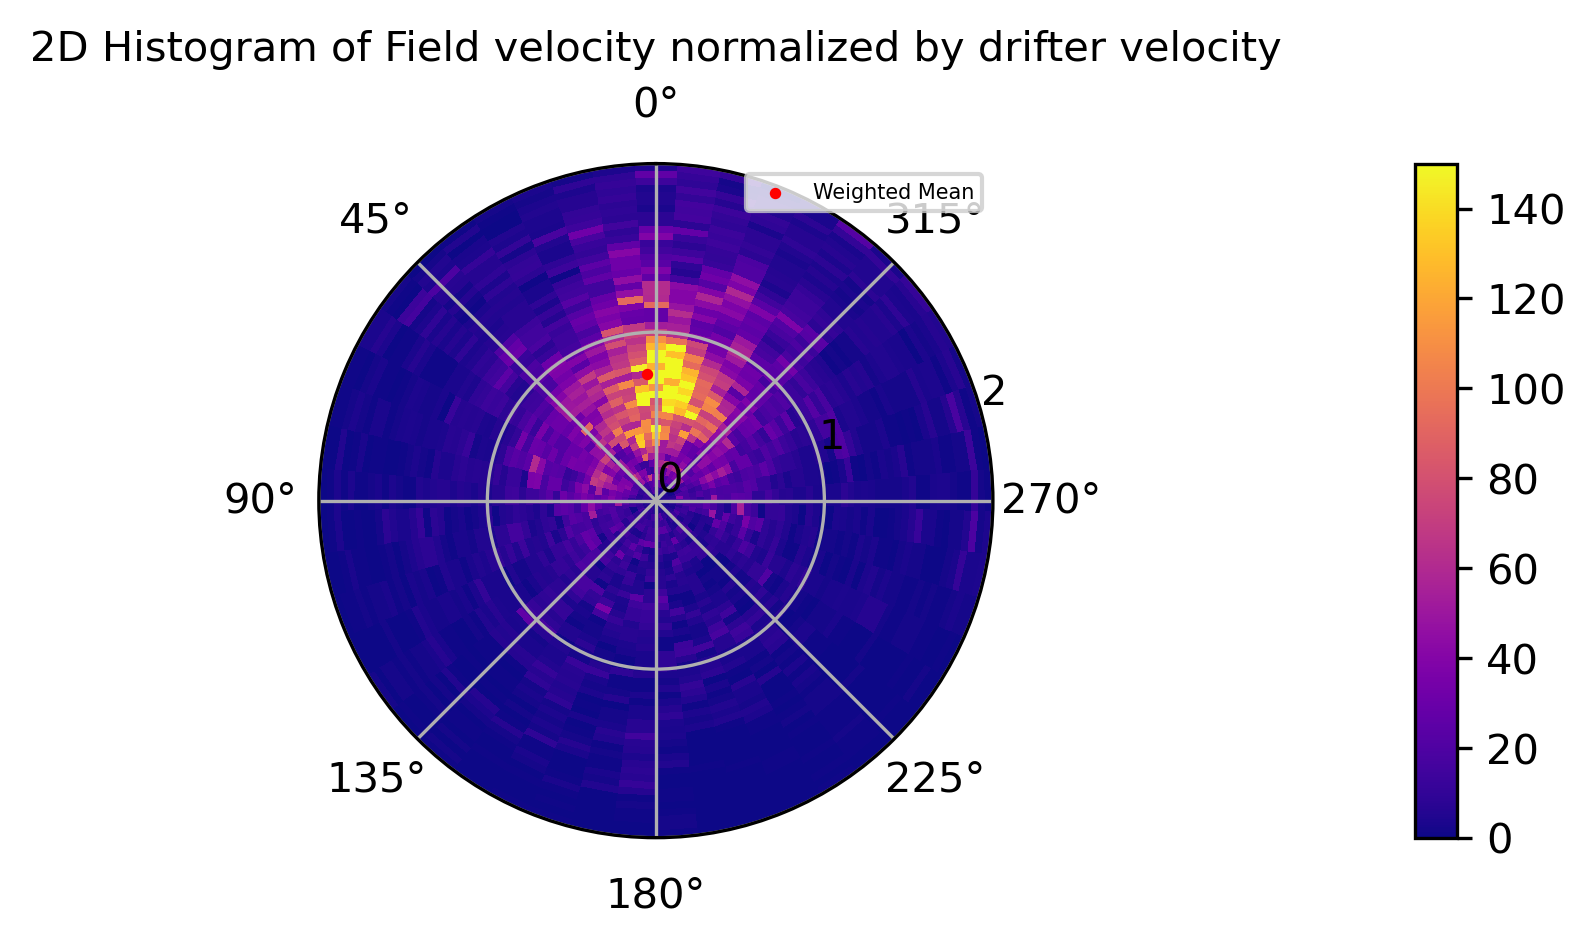

In [15]:
matplotlib.rcParams['figure.dpi'] = 300
utils_plots.plot_2d_polar_hist(r_var, theta_var, rmax=2, vmax = 150, )